<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/images/image_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook contains different methods of embedding images and calculating distances between images.


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle


kaggle.json


In [6]:
!kaggle datasets download -d samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
sports-balls-multiclass-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
import os

# Create the directory if it doesn't exist
!mkdir -p sports-balls-multiclass-image-classification

base_path ='sports-balls-multiclass-image-classification'

# Assuming the zip file is in the current directory and named as downloaded
with zipfile.ZipFile("sports-balls-multiclass-image-classification.zip","r") as zip_ref:
    zip_ref.extractall(base_path)

In [8]:
!pip uninstall -q torch torchvision torchaudio -y
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0+cu118 which is incompatible.


In [9]:
import os
import time
import copy

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim

# Set paths
base_path = 'sports-balls-multiclass-image-classification'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(train_path, data_transforms['train']),
    'test': datasets.ImageFolder(test_path, data_transforms['test'])
}

# Loaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=2),
    'test': DataLoader(image_datasets['test'], batch_size=4, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

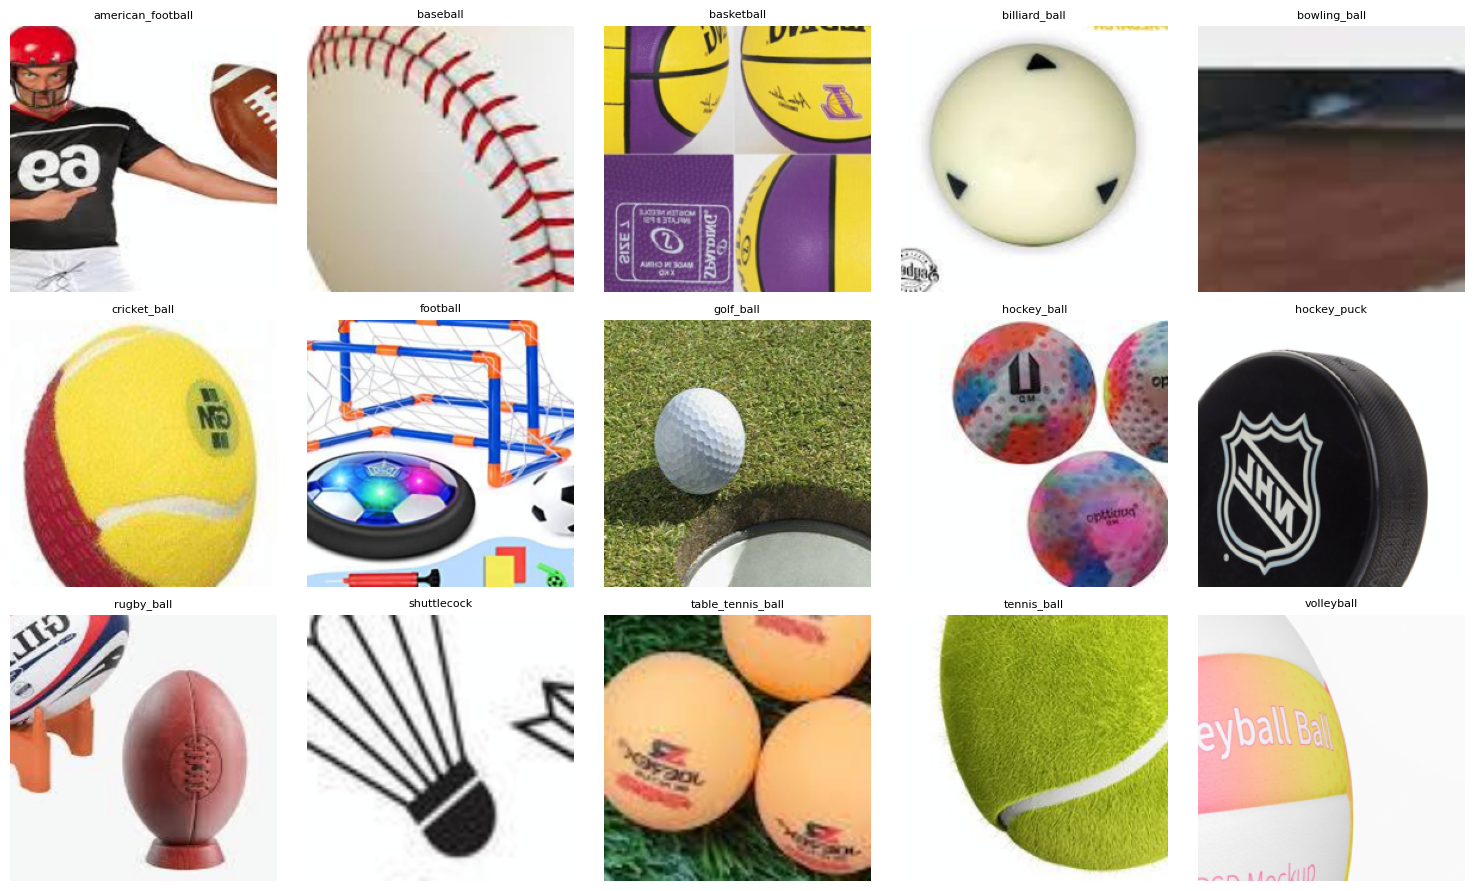

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Helper to unnormalize and show images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=8)
    plt.axis('off')

# Get one image per class
seen_classes = set()
samples_per_class = {}

for img, label in image_datasets['train']:
    class_name = class_names[label]
    if class_name not in seen_classes:
        samples_per_class[class_name] = img
        seen_classes.add(class_name)
    if len(seen_classes) == len(class_names):
        break

# Plot with 5 images per row
n_classes = len(class_names)
cols = 5
rows = (n_classes + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))
for i, (cls, img) in enumerate(samples_per_class.items()):
    plt.subplot(rows, cols, i + 1)
    imshow(img, title=cls)

plt.tight_layout()
plt.show()


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load and modify ResNet-50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training function
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Test Accuracy: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# Train ResNet-50
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=20)

Epoch 1/20
----------
Train Loss: 1.6458 Acc: 0.5104
Test Loss: 1.1195 Acc: 0.7556
Epoch 2/20
----------
Train Loss: 1.2995 Acc: 0.6204
Test Loss: 0.8358 Acc: 0.8066
Epoch 3/20
----------
Train Loss: 1.1359 Acc: 0.6744
Test Loss: 0.9520 Acc: 0.8023
Epoch 4/20
----------
Train Loss: 1.0222 Acc: 0.7056
Test Loss: 0.7667 Acc: 0.8327
Epoch 5/20
----------
Train Loss: 0.9473 Acc: 0.7248
Test Loss: 0.7152 Acc: 0.8441
Epoch 6/20
----------
Train Loss: 0.8761 Acc: 0.7421
Test Loss: 0.5948 Acc: 0.8615
Epoch 7/20
----------
Train Loss: 0.8281 Acc: 0.7571
Test Loss: 0.7991 Acc: 0.8626
Epoch 8/20
----------
Train Loss: 0.7567 Acc: 0.7787
Test Loss: 0.7173 Acc: 0.8517
Epoch 9/20
----------
Train Loss: 0.7392 Acc: 0.7853
Test Loss: 0.6112 Acc: 0.8615
Epoch 10/20
----------
Train Loss: 0.6920 Acc: 0.7946
Test Loss: 0.5320 Acc: 0.8762
Epoch 11/20
----------
Train Loss: 0.6603 Acc: 0.8070
Test Loss: 0.6245 Acc: 0.8707
Epoch 12/20
----------
Train Loss: 0.6531 Acc: 0.8076
Test Loss: 0.6179 Acc: 0.8832
E

In [13]:
from google.colab import drive
drive.mount('/content/drive')

save_directory = "/content/drive/MyDrive/saved_models"
!mkdir -p "{save_directory}"
torch.save(model.state_dict(), os.path.join(save_directory, "sports_ball_classifier.pth"))

Mounted at /content/drive


In [24]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# Assuming you have already mounted your Google Drive and defined save_directory
save_directory = "/content/drive/MyDrive/saved_models"
model_path = os.path.join(save_directory, "sports_ball_classifier.pth")

# Load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Load and preprocess a sample image from test dataset loader
image_path = '/content/sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_1004.jpg'
input_image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    output = model(input_batch)
    logits = output

logits, torch.argmax(logits), class_names[torch.argmax(logits)]

(tensor([[ 0.7883, -0.4613, -0.4011,  1.0374, -2.7065,  9.8945, -2.1054,  0.6599,
          -2.5620, -4.2108,  0.7738, -3.3418,  3.9551,  1.4713, -2.2726]],
        device='cuda:0'),
 tensor(5, device='cuda:0'),
 'cricket_ball')

## Cosine similarity
The model trained has a decent accuracy of 90% which is decent.
if we use the model to extract logits from the last layer, we can see that the cosine similarity betweenn the two items from same label is 0.9433 and anothere label is 0.1241.

In [28]:
from PIL import Image
import torch

# Load and preprocess the first image
image_path_1 = '/content/sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_100.jpg'
input_image_1 = Image.open(image_path_1)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor_1 = preprocess(input_image_1)
input_batch_1 = input_tensor_1.unsqueeze(0).to(device)

# Run inference for the first image
with torch.no_grad():
    output_1 = model(input_batch_1)
    logits_1 = output_1

# Load and preprocess the second image
image_path_2 = '/content/sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_1004.jpg'
input_image_2 = Image.open(image_path_2)
input_tensor_2 = preprocess(input_image_2)
input_batch_2 = input_tensor_2.unsqueeze(0).to(device)

# Run inference for the second image
with torch.no_grad():
    output_2 = model(input_batch_2)
    logits_2 = output_2

# Calculate cosine similarity
from torch.nn import functional as F
cos_sim = F.cosine_similarity(logits_1, logits_2, dim=1)

print("Cosine Similarity:", cos_sim)

# Load and preprocess the second image
image_path_3 = '/content/sports-balls-multiclass-image-classification/train/baseball/baseball_0.jpg'
input_image_3 = Image.open(image_path_3)
input_tensor_3 = preprocess(input_image_3)
input_batch_3 = input_tensor_3.unsqueeze(0).to(device)

# Run inference for the second image
with torch.no_grad():
    output_3 = model(input_batch_3)
    logits_3 = output_3

# Calculate cosine similarity
from torch.nn import functional as F
cos_sim = F.cosine_similarity(logits_2, logits_3, dim=1)

print("Cosine Similarity:", cos_sim)

Cosine Similarity: tensor([0.9433], device='cuda:0')
Cosine Similarity: tensor([0.1241], device='cuda:0')


### Extract embeddings from a pretrained model

In [31]:
model.eval()

# Function to extract embeddings
def extract_embedding(image_path, model, preprocess, device):
    input_image = Image.open(image_path)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
      embedding = model(input_batch)

    return embedding

# Example usage:
image_path_1 = '/content/sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_100.jpg'
embedding_1 = extract_embedding(image_path_1, model, preprocess, device)
print("Embedding 1 shape:", embedding_1.shape)

image_path_2 = '/content/sports-balls-multiclass-image-classification/train/cricket_ball/cricket_ball_1004.jpg'
embedding_2 = extract_embedding(image_path_2, model, preprocess, device)
print("Embedding 2 shape:", embedding_2.shape)

# Calculate cosine similarity between the embeddings
cos_sim = F.cosine_similarity(embedding_1, embedding_2, dim=1)
print("Cosine similarity between embeddings:", cos_sim)

# Accessing model weights
for name, param in model.named_parameters():
    print(f"Layer name: {name}, Weight shape: {param.shape}")

# Accessing transforms (already defined as 'preprocess' in your code)
print("Transforms used:", preprocess)


Embedding 1 shape: torch.Size([1, 15])
Embedding 2 shape: torch.Size([1, 15])
Cosine similarity between embeddings: tensor([0.9433], device='cuda:0')
Layer name: conv1.weight, Weight shape: torch.Size([64, 3, 7, 7])
Layer name: bn1.weight, Weight shape: torch.Size([64])
Layer name: bn1.bias, Weight shape: torch.Size([64])
Layer name: layer1.0.conv1.weight, Weight shape: torch.Size([64, 64, 1, 1])
Layer name: layer1.0.bn1.weight, Weight shape: torch.Size([64])
Layer name: layer1.0.bn1.bias, Weight shape: torch.Size([64])
Layer name: layer1.0.conv2.weight, Weight shape: torch.Size([64, 64, 3, 3])
Layer name: layer1.0.bn2.weight, Weight shape: torch.Size([64])
Layer name: layer1.0.bn2.bias, Weight shape: torch.Size([64])
Layer name: layer1.0.conv3.weight, Weight shape: torch.Size([256, 64, 1, 1])
Layer name: layer1.0.bn3.weight, Weight shape: torch.Size([256])
Layer name: layer1.0.bn3.bias, Weight shape: torch.Size([256])
Layer name: layer1.0.downsample.0.weight, Weight shape: torch.Size(

Remove the last FC layer from resnet50 trained model and then find cosine similarty.

In [45]:
embedder = nn.Sequential(*list(model.children())[:-1])
embedder.eval()

input_image = Image.open(image_path_1)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.inference_mode():
  embedding_1 = embedder(input_batch).squeeze()
  print(embedding_1.shape)

input_image = Image.open(image_path_2)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.inference_mode():
  embedding_2 = embedder(input_batch).squeeze()
  print(embedding_2.shape)

F.cosine_similarity(embedding_1, embedding_2, dim=0)

torch.Size([2048])
torch.Size([2048])


tensor(0.9948, device='cuda:0')